# Game week points prediction model v2

In [1]:
import warnings
import pandas as pd
import requests
import os
import json
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')
sns.set()

## Fetch Data from the FPL API

In [2]:
def get_fpl_data(endpoint):
    url = f'https://fantasy.premierleague.com/api/{endpoint}/'
    response = requests.get(url)
    response.raise_for_status()
    return response.json()
    
bootstrap_data = get_fpl_data('bootstrap-static')
elements_data = bootstrap_data['elements']
fixtures = get_fpl_data('fixtures')
positions_data = bootstrap_data['element_types']
teams = {team['id']: team['name'] for team in bootstrap_data['teams']}

# Convert to DataFrames
players_df = pd.DataFrame(elements_data)
positions_df = pd.DataFrame(positions_data)
fixtures_df = pd.DataFrame(fixtures)
teams_df = pd.DataFrame(list(teams.items()), columns=['team_id', 'team'])

# save data
players_df.to_csv("players_df.csv", index=False)
teams_df.to_csv("teams_df.csv", index=False)
positions_df.to_csv("positions_df.csv", index=False)
fixtures_df.to_csv("fixtures_df.csv", index=False)
teams_df.to_csv("teams_df.csv", index=False)

In [3]:
# # Load data
# players_df = pd.read_csv("players_df.csv") # will need to refresh this df in production
# teams_df = pd.read_csv("teams_df.csv")
# positions_df = pd.read_csv("positions_df.csv")
# fixtures_df = pd.read_csv("fixtures_df.csv")
# teams_df = pd.read_csv("teams_df.csv")

In [4]:
# Load gameweek data
gw_all_with_difficulty_df = pd.read_csv("data/gw_all_with_difficulty.csv")

## Data prep

In [5]:
# Player data

# players_df = players_df[['id', 'web_name', 'team', 'element_type', 'now_cost', 'total_points', 'minutes', 'points_per_game', 'value_season', 'status']]
players_df['now_cost'] = players_df['now_cost'] / 10  # Convert cost to millions
players_df['value_season'] = pd.to_numeric(players_df['value_season'], errors='coerce')
available_players_df = players_df[players_df['status'] == 'a']
available_players_df['roi'] = available_players_df['total_points'] / (available_players_df['now_cost'] / 10)
position_mapping = positions_df.set_index('id')['singular_name_short'].to_dict()
available_players_df['position'] = available_players_df['element_type'].map(position_mapping)
available_players_df['points_per_game'] = pd.to_numeric(available_players_df['points_per_game'], errors='coerce')
available_players_df.to_csv("available_players_df.csv", index=False)
gw_all_with_difficulty_df.rename(columns={"total_points":"total_points_gw",
                                         "ict_index":"ict_index_gw",
                                         "starts":"starts_gw"}, inplace=True)

In [6]:
# Fixture and team data

fixtures_df['team_h'] = fixtures_df['team_h'].map(teams)
fixtures_df['team_a'] = fixtures_df['team_a'].map(teams)

team_h_difficulty = fixtures_df.groupby('team_h')['team_h_difficulty'].mean().reset_index()
team_a_difficulty = fixtures_df.groupby('team_a')['team_a_difficulty'].mean().reset_index()

team_h_difficulty.columns = ['team', 'avg_home_difficulty']
team_a_difficulty.columns = ['team', 'avg_away_difficulty']

team_difficulty = pd.merge(team_h_difficulty, team_a_difficulty, on='team', how='outer')

team_difficulty['avg_difficulty'] = team_difficulty[['avg_home_difficulty', 'avg_away_difficulty']].mean(axis=1)

team_difficulty = team_difficulty.merge(teams_df, on="team")
team_difficulty.to_csv("team_difficulty.csv",index=False)

team_difficulty_mapping = team_difficulty.set_index('team_id')['avg_difficulty'].to_dict()

fixtures_df['opponent_team_difficulty'] = fixtures_df['team_a'].map(team_difficulty_mapping)

In [7]:
fixtures_df

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,opponent_team_difficulty
0,2444470,1,False,False,1,2024-08-16T19:00:00Z,0,False,False,Fulham,None,Man Utd,None,[],2,3,115827,NaN
1,2444473,1,False,False,4,2024-08-17T11:30:00Z,0,False,False,Liverpool,None,Ipswich,None,[],4,2,115830,NaN
2,2444471,1,False,False,2,2024-08-17T14:00:00Z,0,False,False,Wolves,None,Arsenal,None,[],2,5,115828,NaN
3,2444472,1,False,False,3,2024-08-17T14:00:00Z,0,False,False,Brighton,None,Everton,None,[],2,3,115829,NaN
4,2444474,1,False,False,5,2024-08-17T14:00:00Z,0,False,False,Southampton,None,Newcastle,None,[],2,4,115831,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2444845,38,False,False,376,2025-05-25T15:00:00Z,0,False,False,Everton,None,Newcastle,None,[],2,4,116202,NaN
376,2444846,38,False,False,377,2025-05-25T15:00:00Z,0,False,False,Chelsea,None,Nott'm Forest,None,[],3,2,116203,NaN
377,2444847,38,False,False,378,2025-05-25T15:00:00Z,0,False,False,Arsenal,None,Southampton,None,[],5,2,116204,NaN
378,2444848,38,False,False,379,2025-05-25T15:00:00Z,0,False,False,Brighton,None,Spurs,None,[],2,4,116205,NaN


In [8]:
# add new gw data

# gw_data = fet_gw_data() todo: create api call for this
# gw_data_with_difficulty = pd.merge(gw_data, team_difficulty, left_on='team', right_on='team', how='left')
# gw_data_with_difficulty['opponent_team_difficulty'] = gw_data_with_difficulty['opponent_team'].map(team_difficulty_mapping)
# gw_all_with_difficulty_df = pd.concat([gw_all_with_difficulty_df, gw_data_with_difficulty])

In [9]:
columns_to_drop = [
    'goals_scored', 'assists', 'clean_sheets', 
    'goals_conceded', 'own_goals', 'penalties_missed', 'penalties_saved', 
    'red_cards', 'saves', 'team_a_score', 'team_h_score', 
    'yellow_cards', 'round', 'kickoff_time', 'selected', 
    'transfers_in', 'transfers_out',
    'expected_assists', 'expected_goal_involvements', 'expected_goals',
    'expected_goals_conceded', 'creativity', 'influence', 'bonus',
    'bps', 'minutes', 'xP', 'element', 'fixture', 'threat'
]
cleaned_gw_data = gw_all_with_difficulty_df.drop(columns=columns_to_drop)

cleaned_gw_data.head()

,name,position,team,ict_index_gw,opponent_team,starts_gw,total_points_gw,transfers_balance,value,was_home,avg_home_difficulty,avg_away_difficulty,avg_difficulty,team_id,opponent_team_difficulty
0,Femi Seriki,DEF,Sheffield Utd,0.0,8,0,0,0,40,True,NaN,NaN,NaN,NaN,2.868421
1,Jack Hinshelwood,MID,Brighton,0.0,12,0,0,0,45,True,2.684211,3.105263,2.894737,5.0,2.763158
2,Jadon Sancho,MID,Man Utd,2.3,20,0,1,0,70,True,2.631579,3.052632,2.842105,14.0,2.894737
3,Rhys Norrington-Davies,DEF,Sheffield Utd,0.0,8,0,0,0,40,True,NaN,NaN,NaN,NaN,2.868421
4,Vitaly Janelt,MID,Brentford,4.3,18,1,2,0,55,True,2.684211,3.105263,2.894737,4.0,2.815789


## Exploratory data analysis

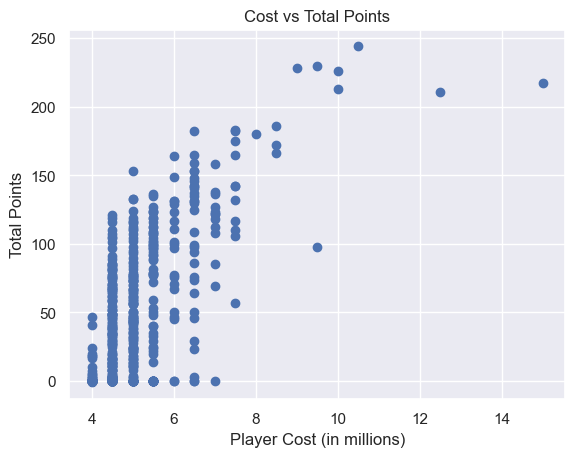

,id,web_name,team,element_type,now_cost,total_points,minutes,points_per_game,value_season,status
236,235,Pickford,8,1,5.0,153,3420,4.0,30.6,a
23,24,White,1,2,6.5,182,2987,4.9,28.0,a
17,18,Saliba,1,2,6.0,164,3420,4.3,27.3,a
193,191,Andersen,7,2,4.5,121,3416,3.2,26.9,a
249,248,Leno,9,1,5.0,133,3420,3.5,26.6,a


In [10]:
# Correlation between cost and total points
plt.scatter(available_players_df['now_cost'], available_players_df['total_points'])
plt.xlabel('Player Cost (in millions)')
plt.ylabel('Total Points')
plt.title('Cost vs Total Points')
plt.show()

# Calculate ROI: Total points per million spent
available_players_df['roi'] = available_players_df['total_points'] / available_players_df['now_cost']

# Top 20 players by ROI
top_5_roi = available_players_df.nlargest(5, 'roi')
top_5_roi[['id', 'web_name', 'team', 'element_type', 'now_cost', 'total_points', 'minutes', 'points_per_game', 'value_season', 'status']]

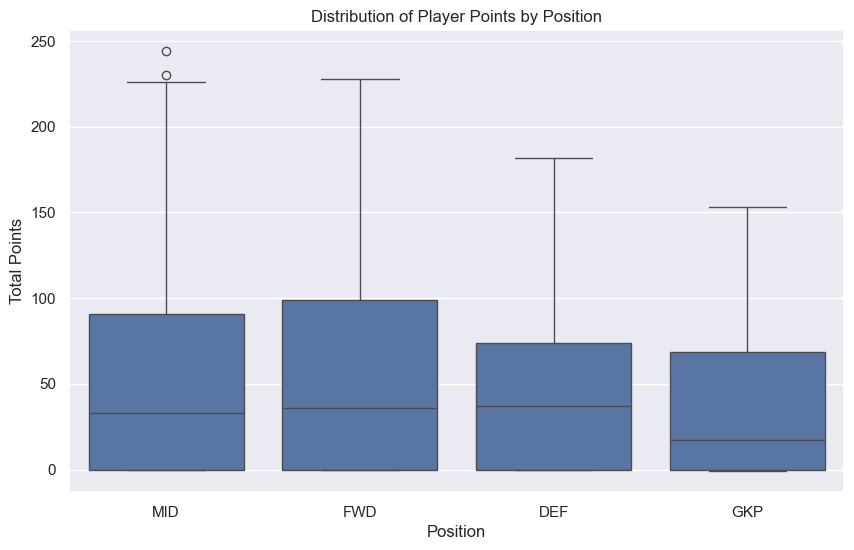

In [11]:
# Distribution of Player Points by Position
plt.figure(figsize=(10, 6))
sns.boxplot(x='position', y='total_points', data=available_players_df)
plt.xlabel('Position')
plt.ylabel('Total Points')
plt.title('Distribution of Player Points by Position')
plt.show()

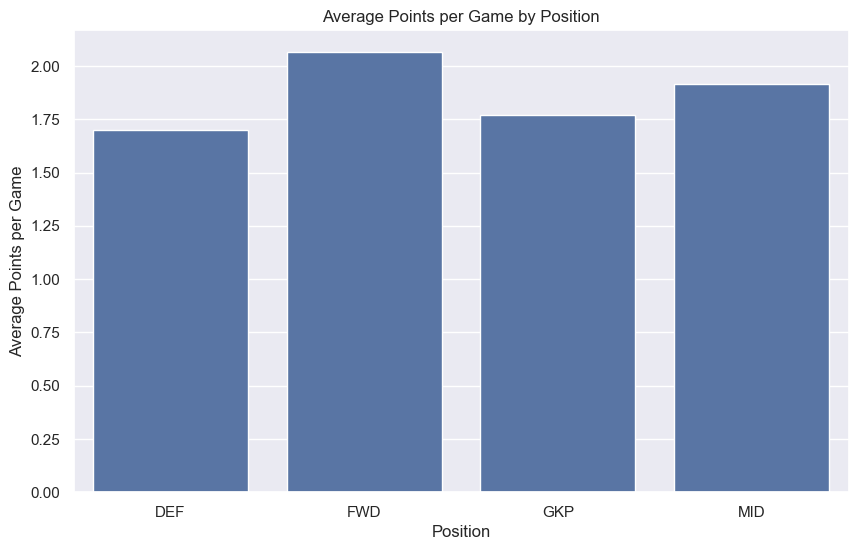

In [12]:
# Average Points per Game by Position
avg_points_per_game = available_players_df.groupby('position')['points_per_game'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='position', y='points_per_game', data=avg_points_per_game)
plt.xlabel('Position')
plt.ylabel('Average Points per Game')
plt.title('Average Points per Game by Position')
plt.show()

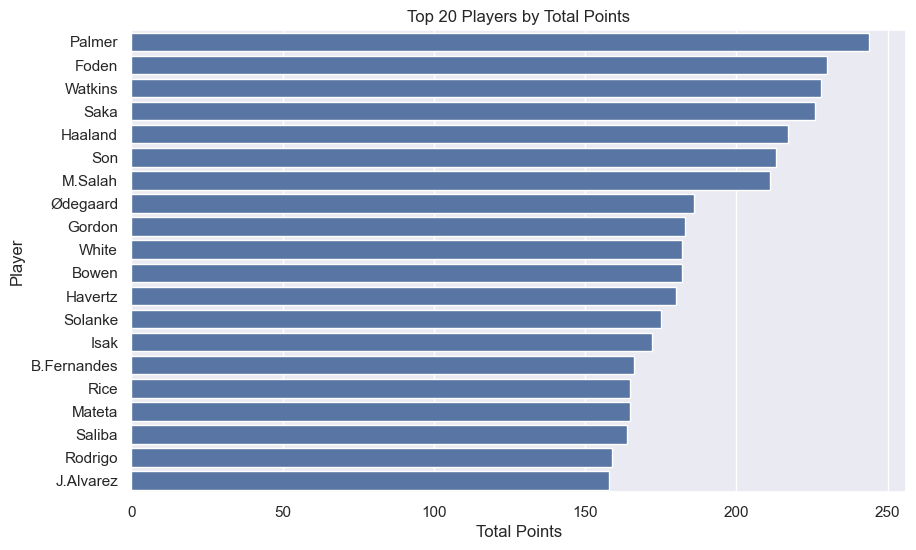

In [13]:
top_players = available_players_df.nlargest(20, 'total_points')
plt.figure(figsize=(10, 6))
sns.barplot(x='total_points', y='web_name', data=top_players)
plt.xlabel('Total Points')
plt.ylabel('Player')
plt.title('Top 20 Players by Total Points')
plt.show()

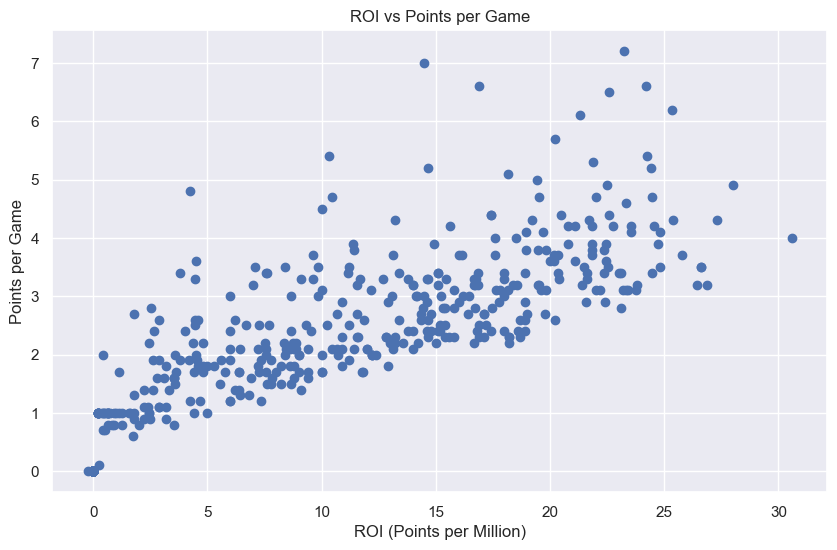

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(available_players_df['roi'], available_players_df['points_per_game'])
plt.xlabel('ROI (Points per Million)')
plt.ylabel('Points per Game')
plt.title('ROI vs Points per Game')
plt.show()

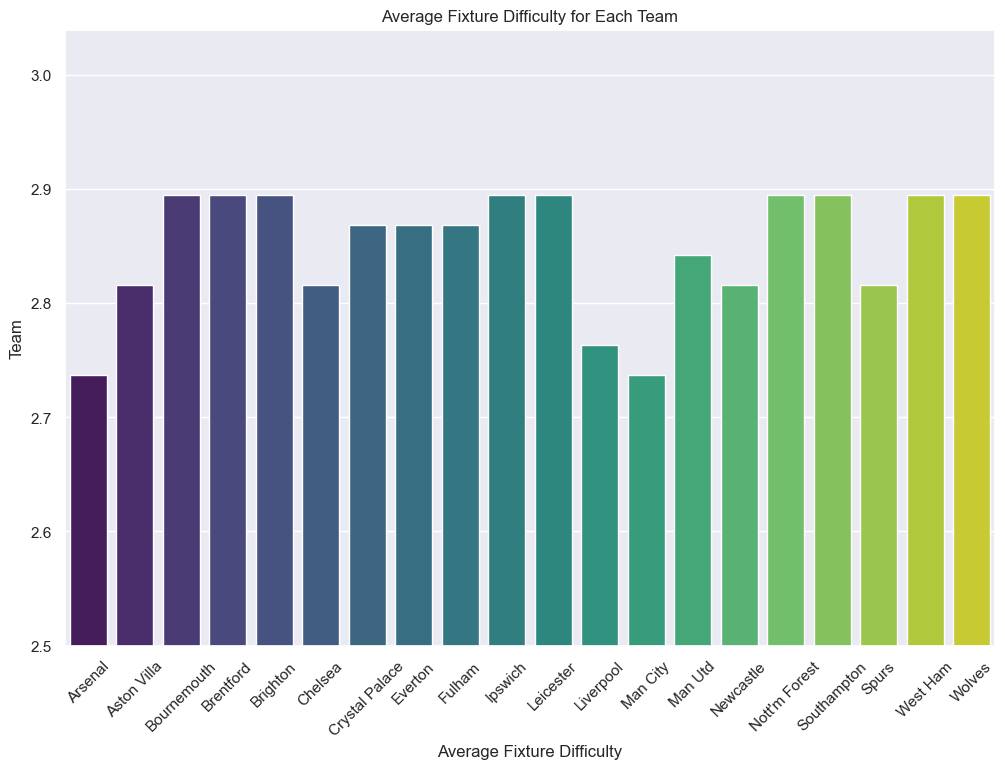

In [15]:
# Plot the fixture difficulty for each team
plt.figure(figsize=(12, 8))
sns.barplot(x='team', y='avg_difficulty', data=team_difficulty, palette='viridis')
plt.xlabel('Average Fixture Difficulty')
plt.ylim(2.5)
plt.ylabel('Team')
plt.xticks(rotation=45)
plt.title('Average Fixture Difficulty for Each Team')
plt.show()

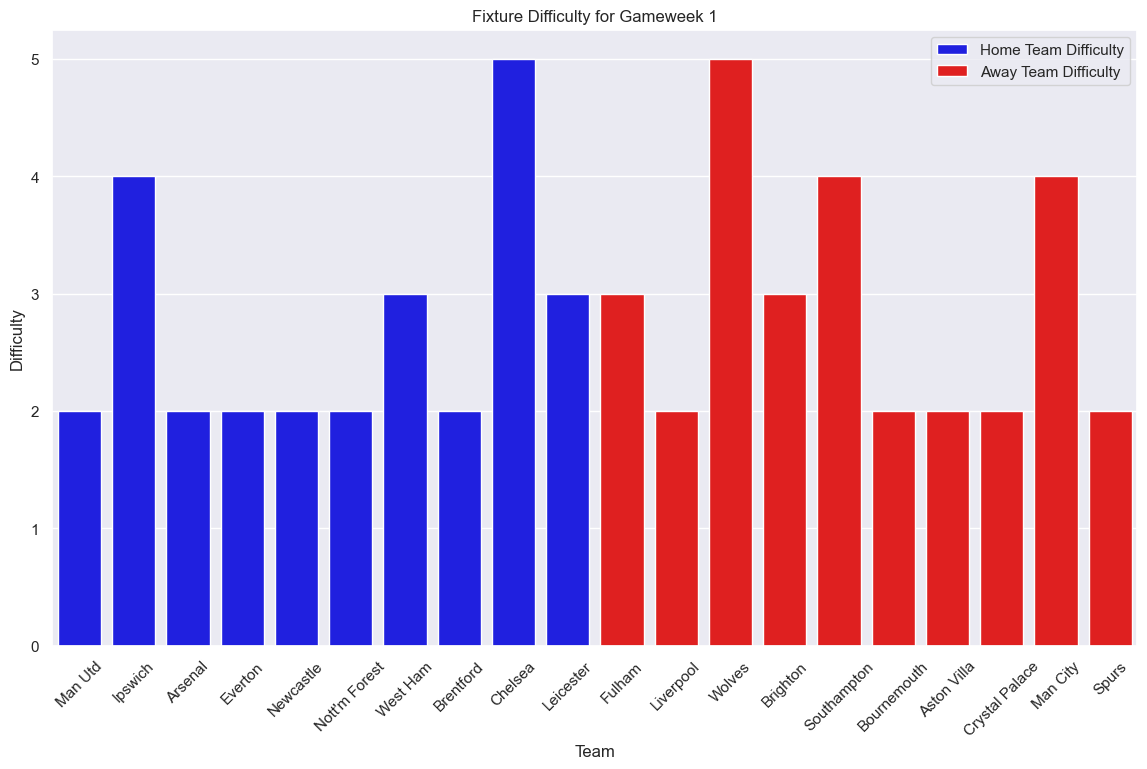

In [16]:
# Function to plot fixture difficulty for a chosen gameweek
def plot_fixture_difficulty(gameweek):
    # Filter for the chosen gameweek
    gw_fixtures_df = fixtures_df[fixtures_df['event'] == gameweek]
    
    if gw_fixtures_df.empty:
        print(f"No fixtures found for gameweek {gameweek}.")
        return
    
    # Plot the fixture difficulty for the chosen gameweek
    plt.figure(figsize=(14, 8))
    
    # Home teams
    sns.barplot(
        x='team_h',
        y='team_h_difficulty',
        data=gw_fixtures_df,
        color='blue',
        label='Home Team Difficulty'
    )
    
    # Away teams
    sns.barplot(
        x='team_a',
        y='team_a_difficulty',
        data=gw_fixtures_df,
        color='red',
        label='Away Team Difficulty'
    )
    
    plt.xlabel('Team')
    plt.ylabel('Difficulty')
    plt.title(f'Fixture Difficulty for Gameweek {gameweek}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

# Example usage: Plot fixture difficulty for gameweek 5
plot_fixture_difficulty(1)

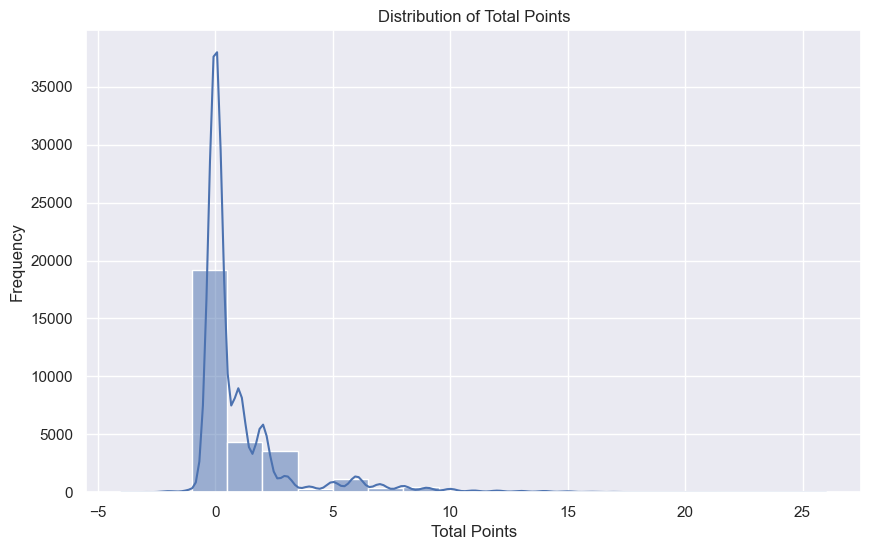

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_gw_data['total_points_gw'], bins=20, kde=True)
plt.xlabel('Total Points')
plt.ylabel('Frequency')
plt.title('Distribution of Total Points')
plt.grid(True)
plt.show()

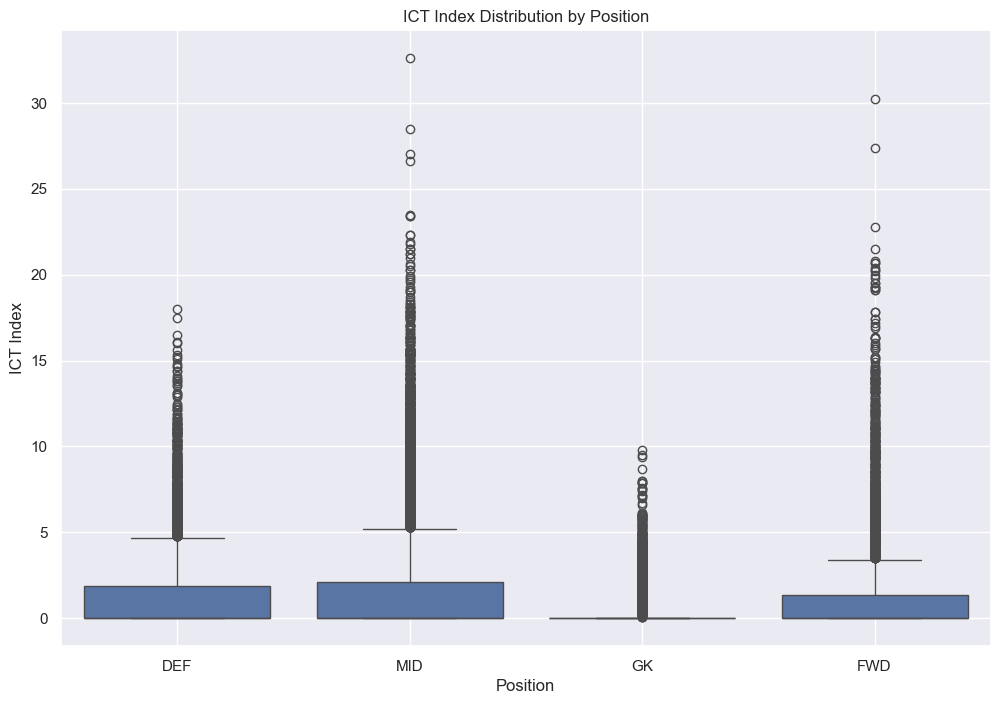

In [18]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='position', y='ict_index_gw', data=cleaned_gw_data)
plt.xlabel('Position')
plt.ylabel('ICT Index')
plt.title('ICT Index Distribution by Position')
plt.grid(True)
plt.show()

In [19]:
cleaned_gw_data.columns

Index(['name', 'position', 'team', 'ict_index_gw', 'opponent_team',
       'starts_gw', 'total_points_gw', 'transfers_balance', 'value',
       'was_home', 'avg_home_difficulty', 'avg_away_difficulty',
       'avg_difficulty', 'team_id', 'opponent_team_difficulty'],
      dtype='object')

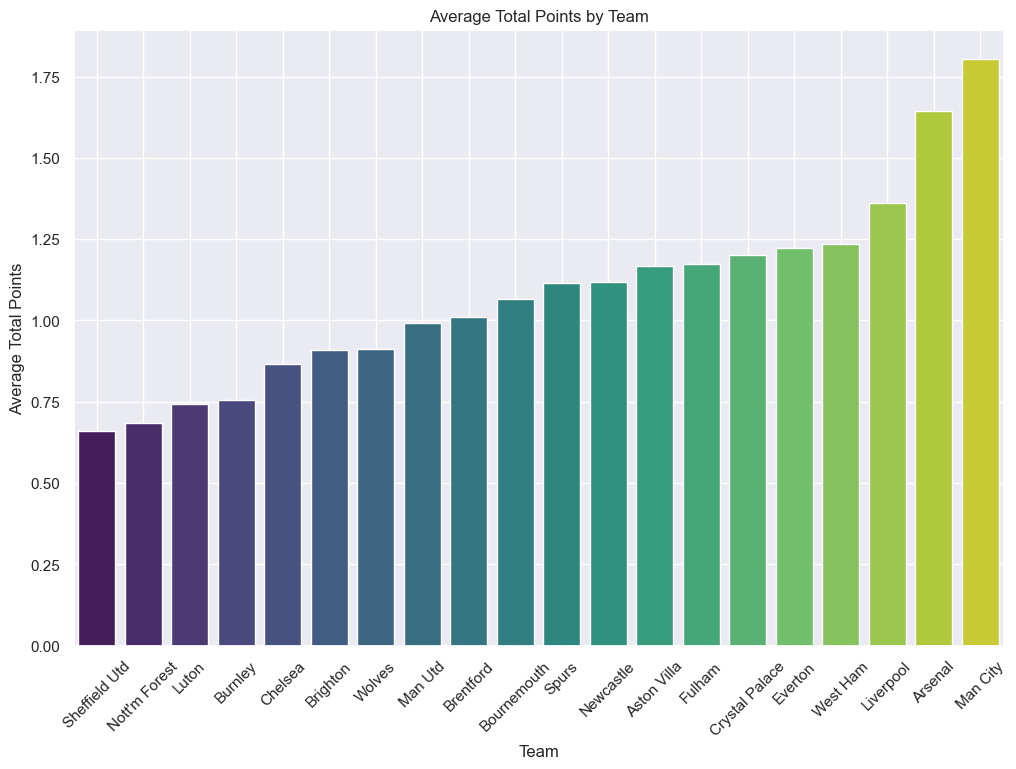

In [20]:
plt.figure(figsize=(12, 8))
team_avg_points = cleaned_gw_data.groupby('team')['total_points_gw'].mean().sort_values()
sns.barplot(x=team_avg_points.index, y=team_avg_points.values, palette='viridis')
plt.xlabel('Team')
plt.ylabel('Average Total Points')
plt.title('Average Total Points by Team')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

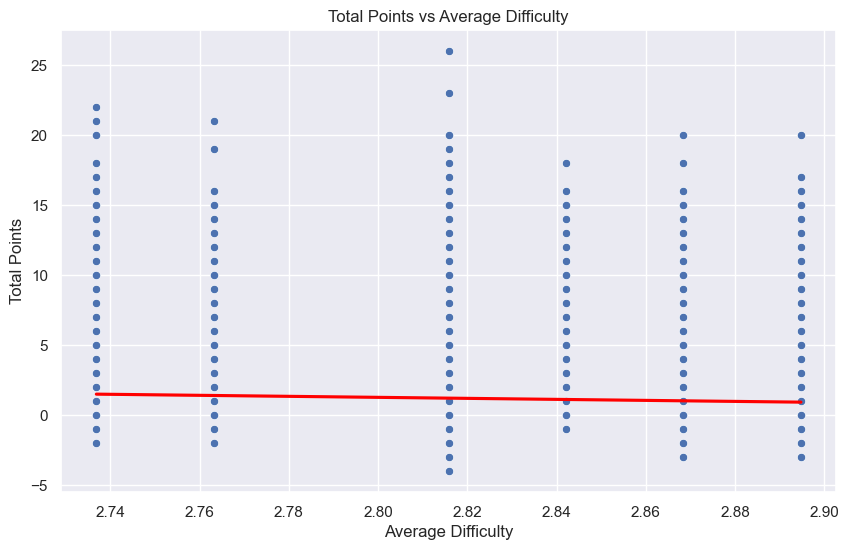

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_difficulty', y='total_points_gw', data=cleaned_gw_data)
sns.regplot(x='avg_difficulty', y='total_points_gw', data=cleaned_gw_data, scatter=False, color='red')
plt.xlabel('Average Difficulty')
plt.ylabel('Total Points')
plt.title('Total Points vs Average Difficulty')
plt.grid(True)
plt.show()

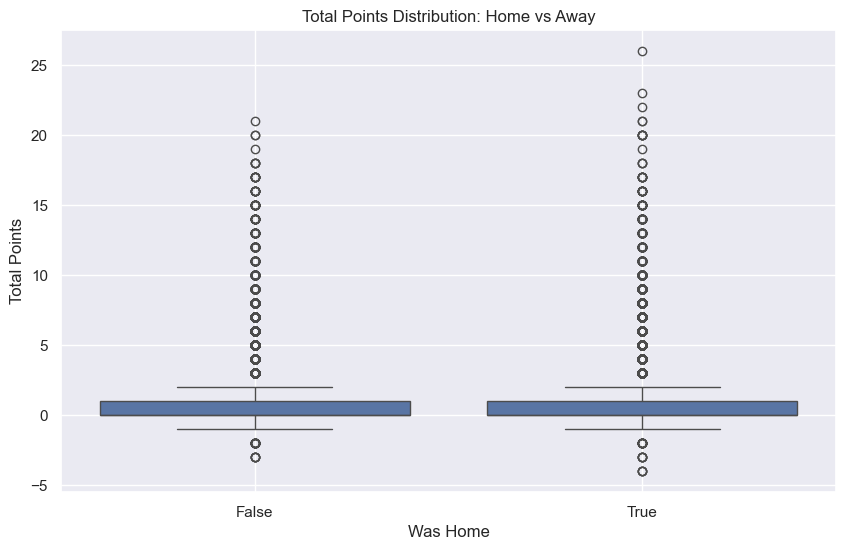

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='was_home', y='total_points_gw', data=cleaned_gw_data)
plt.xlabel('Was Home')
plt.ylabel('Total Points')
plt.title('Total Points Distribution: Home vs Away')
plt.grid(True)
plt.show()

In [38]:
cleaned_gw_data.to_csv("cleaned_gw_data.csv", index=False)

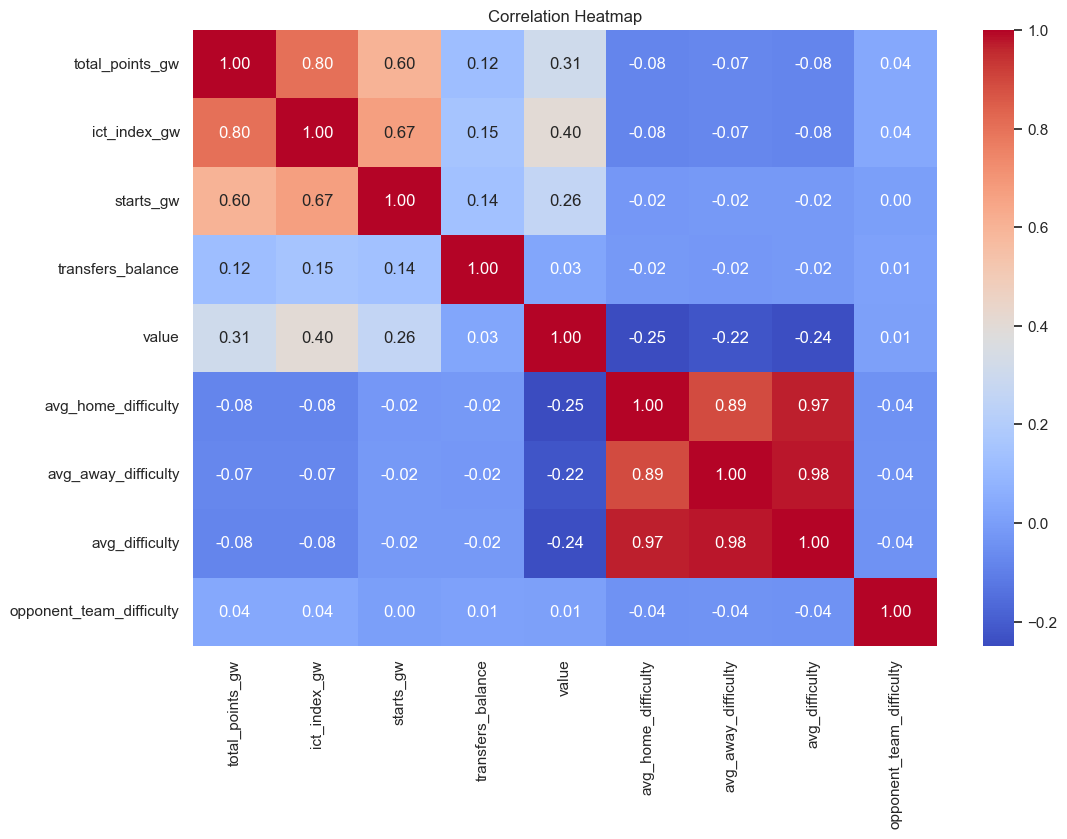

In [23]:
plt.figure(figsize=(12, 8))
corr_matrix = cleaned_gw_data[['total_points_gw', 'ict_index_gw', 'starts_gw', 'transfers_balance', 'value',
                              'avg_home_difficulty', 'avg_away_difficulty', 'avg_difficulty',
                              'opponent_team_difficulty']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [24]:
important_features = [
    "total_points",
    "form",
    "minutes",
    "goals_scored",
    "assists",
    "clean_sheets",
    "goals_conceded",
    "yellow_cards",
    "red_cards",
    "bonus",
    "starts",
    "expected_goals",
    "expected_assists",
    "expected_goal_involvements",
    "selected_by_percent",
    "value_season",
    "value_form",
    "influence_rank",
    "influence_rank_type",
    "creativity_rank",
    "creativity_rank_type",
    "threat_rank",
    "threat_rank_type",
    "ict_index_rank",
    "ict_index_rank_type",
    "now_cost_rank",
    "now_cost_rank_type",
    "form_rank",
    "form_rank_type",
    "points_per_game_rank",
    "points_per_game_rank_type",
    "selected_rank",
    "selected_rank_type",
    "starts_per_90",
    "clean_sheets_per_90"
]

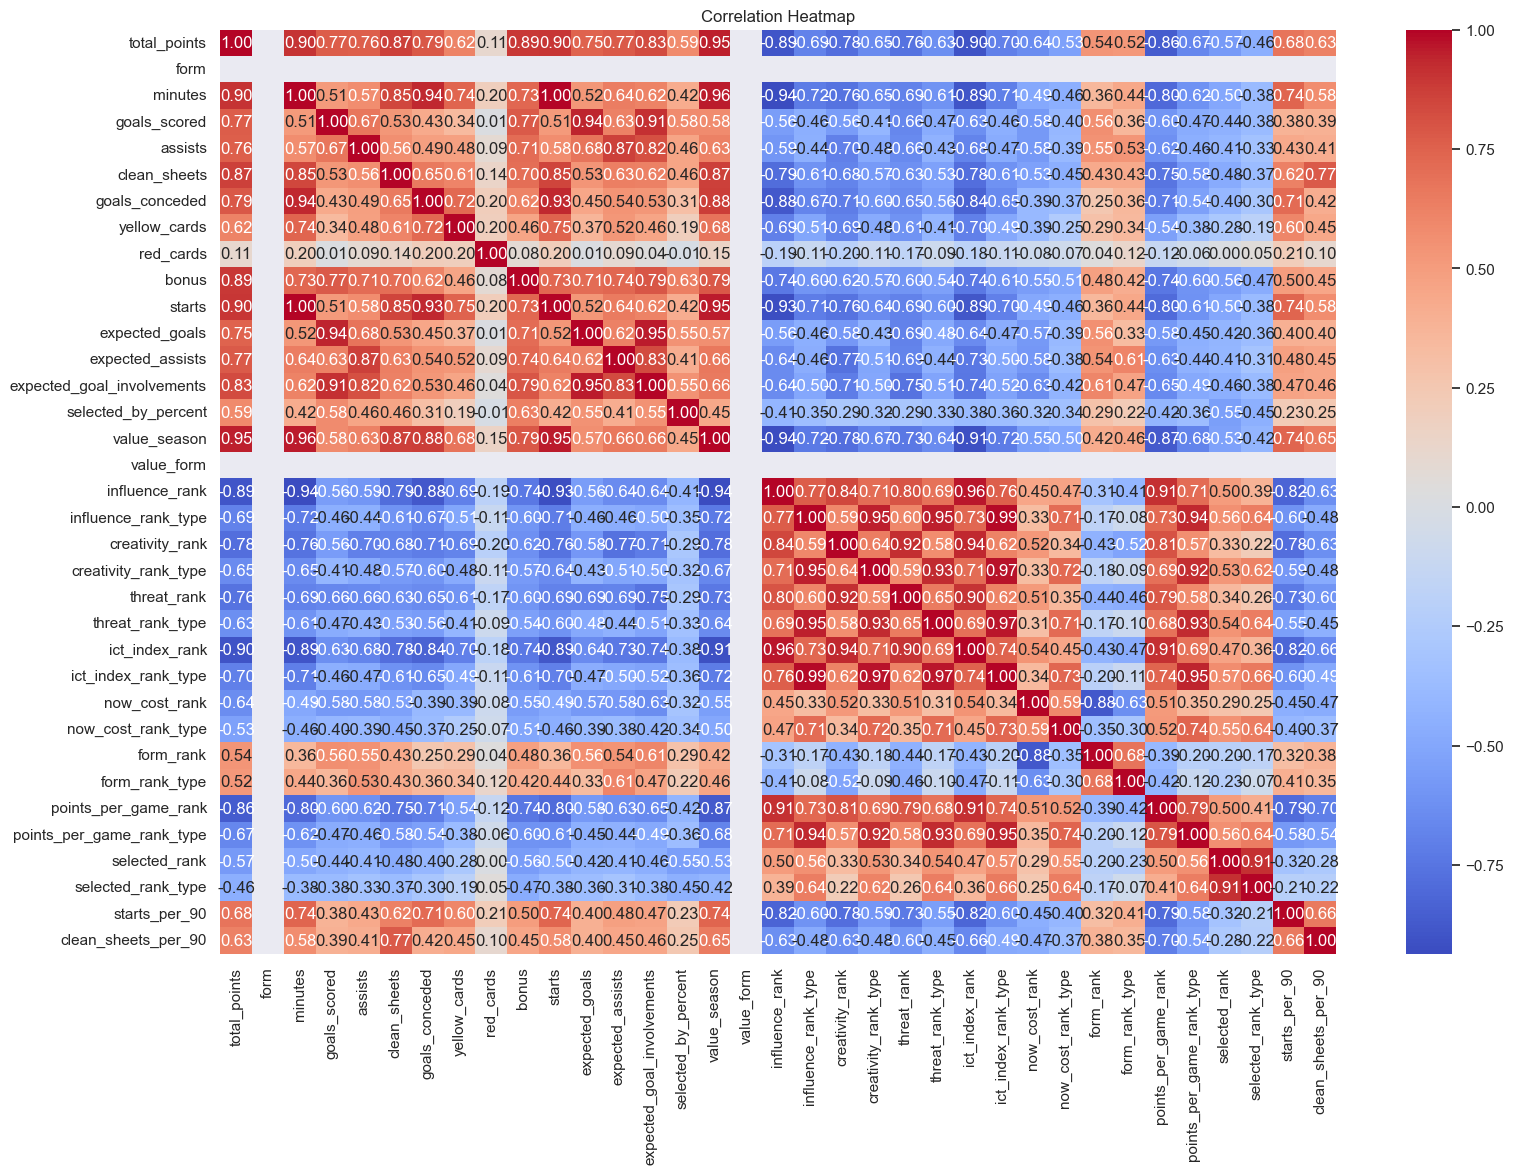

In [25]:
plt.figure(figsize=(18, 12))
corr_matrix = players_df[important_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

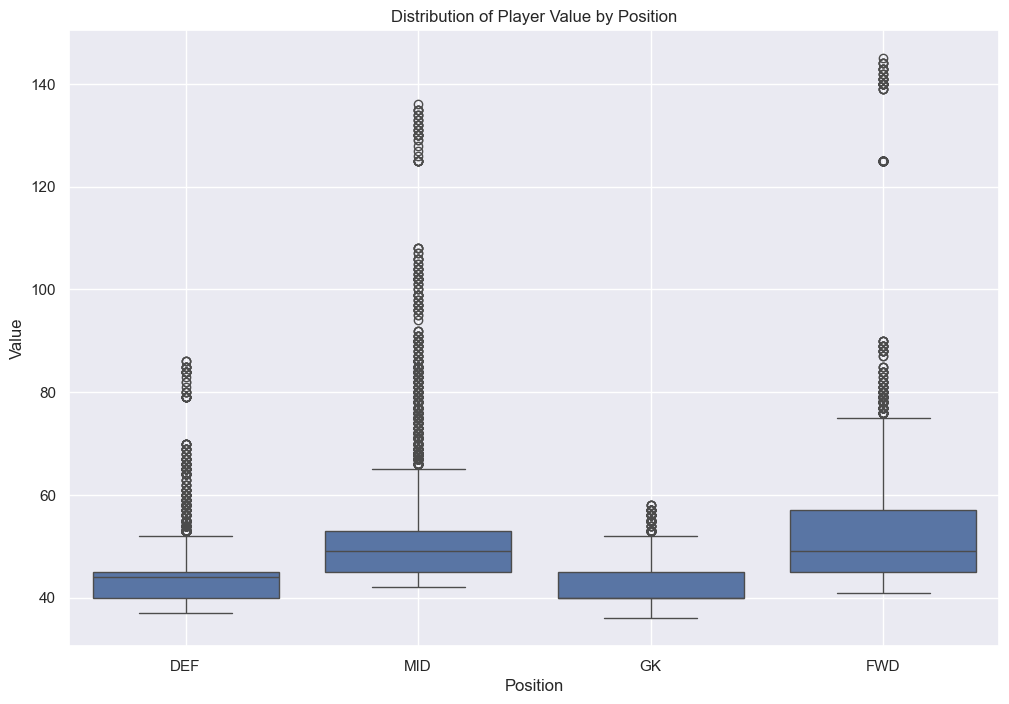

In [26]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='position', y='value', data=cleaned_gw_data)
plt.xlabel('Position')
plt.ylabel('Value')
plt.title('Distribution of Player Value by Position')
plt.grid(True)
plt.show()

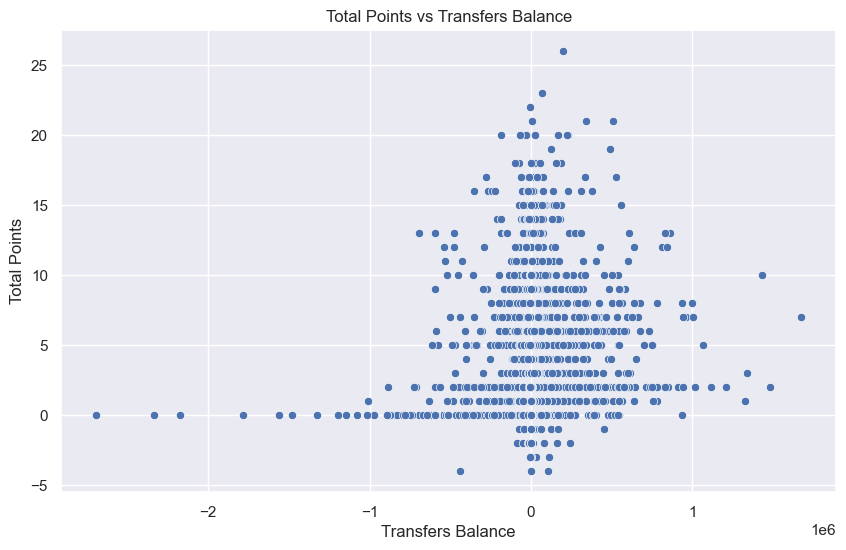

In [27]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='transfers_balance', y='total_points_gw', data=cleaned_gw_data)
plt.xlabel('Transfers Balance')
plt.ylabel('Total Points')
plt.title('Total Points vs Transfers Balance')
plt.grid(True)
plt.show()

## Merge gw and available player data

In [28]:
players_df["name_substring"] = players_df["second_name"].apply(lambda x: x.split(" ")[-1] if pd.notna(x) else x)
cleaned_gw_data["name_substring"] = cleaned_gw_data["name"].apply(lambda x: x.split(" ")[-1] if pd.notna(x) else x)
players_df["team_id"] = players_df["team"].apply(lambda x: float(x) if pd.notna(x) else x)
cleaned_gw_data.rename(columns={"team":"team_name"}, inplace=True)

In [29]:
total_player_df = players_df.merge(cleaned_gw_data, on = ["name_substring","team_id"], how = "left")

In [30]:
all_na_columns = total_player_df.columns[total_player_df.isna().all()].tolist()

In [31]:
total_player_df.drop(columns=all_na_columns, inplace=True)

In [32]:
# dtypes_df = total_player_df.dtypes.reset_index()
# dtypes_df.columns = ['Column', 'DataType']
# dtypes_df.to_csv("dtypes_df.csv",index=False)

## Handling missing values

In [33]:
# Assuming total_player_df is your DataFrame
# Check for missing values
missing_values = total_player_df.isnull().sum()
print("Missing values before handling:")
print(missing_values[missing_values > 0])

# Define columns by data type
numerical_cols = total_player_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = total_player_df.select_dtypes(include=['object']).columns

# Handle missing values for numerical columns
numerical_imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
total_player_df[numerical_cols] = numerical_imputer.fit_transform(total_player_df[numerical_cols])

# Handle missing values for categorical columns
# For categorical columns, you might want to fill missing values with the most frequent value or create a new category
categorical_imputer = SimpleImputer(strategy='most_frequent')
total_player_df[categorical_cols] = categorical_imputer.fit_transform(total_player_df[categorical_cols])

# Check for any remaining missing values
missing_values_after = total_player_df.isnull().sum()
print("Missing values after handling:")
print(missing_values_after[missing_values_after > 0])

# Additional steps based on domain knowledge:
# For columns with `bool` type, you might replace NaNs with `False` or `True` depending on the context
# For `object` type columns with specific values, you might need to check if the replacement is appropriate

# Example: Filling boolean columns with False if NaN
boolean_cols = total_player_df.select_dtypes(include=['bool']).columns
total_player_df[boolean_cols] = total_player_df[boolean_cols].fillna(False)

# Example: Converting categorical columns that had NaNs to a new category
total_player_df[categorical_cols] = total_player_df[categorical_cols].fillna('Unknown')

print("DataFrame after handling missing values:")
print(total_player_df.head())


Missing values before handling:
chance_of_playing_next_round            15535
news_added                              15536
corners_and_indirect_freekicks_order    13962
direct_freekicks_order                  14319
penalties_order                         14580
name                                      140
position                                  140
team_name                                 140
ict_index_gw                              140
opponent_team                             140
starts_gw                                 140
total_points_gw                           140
transfers_balance                         140
value                                     140
was_home                                  140
avg_home_difficulty                       140
avg_away_difficulty                       140
avg_difficulty                            140
opponent_team_difficulty                  140
dtype: int64
Missing values after handling:
news_added    15536
dtype: int64
DataFrame after h

In [34]:
one_hot_encoded_columns = ['status', 'was_home', 'position', 'team', 'opponent_team']
total_player_df = pd.get_dummies(total_player_df, columns=one_hot_encoded_columns)
boolean_columns = ['in_dreamteam', 'special']
total_player_df[boolean_columns] = total_player_df[boolean_columns].astype(int)

## Modelling

In [35]:
total_player_df.dtypes

chance_of_playing_next_round    float64
code                            float64
cost_change_event               float64
cost_change_event_fall          float64
cost_change_start               float64
                                 ...   
opponent_team_16.0                 bool
opponent_team_17.0                 bool
opponent_team_18.0                 bool
opponent_team_19.0                 bool
opponent_team_20.0                 bool
Length: 147, dtype: object

In [36]:
X = total_player_df.drop(columns=['total_points_gw','first_name', 'second_name', 'name', 'web_name', 'name_substring', 'news', 'news_added', 'photo'])
y = total_player_df['total_points_gw']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

ValueError: could not convert string to float: ''

In [ ]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Optionally, plot predictions vs. actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Total Points GW')
plt.ylabel('Predicted Total Points GW')
plt.title('Actual vs. Predicted Total Points GW')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()

In [ ]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for plotting
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
})

# Sort by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Predicting Total Points')
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.show()